In [2]:
%pip install torchvision

Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.


   ---------------------------------------- 0.0/4.3 MB ? eta -:--:--
   ---------------------------------------- 4.3/4.3 MB 48.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/110.9 MB ? eta -:--:--
   ------- -------------------------------- 20.2/110.9 MB 94.0 MB/s eta 0:00:01
   -------------- ------------------------ 41.9/110.9 MB 102.0 MB/s eta 0:00:01
   --------------------- ----------------- 61.3/110.9 MB 100.0 MB/s eta 0:00:01
   ----------------------------- ---------- 82.1/110.9 MB 99.8 MB/s eta 0:00:01
   ----------------------------------- ---- 98.3/110.9 MB 98.8 MB/s eta 0:00:01
   --------------------------------------  110.9/110.9 MB 97.1 MB/s eta 0:00:01
   --------------------------------------- 110.9/110.9 MB 87.5 MB/s eta 0:00:00

  Attempting uninstall: torch

    Found existing installation: torch 2.9.0

   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ------------------------------

In [3]:
import torch
import torchvision.datasets as datasets
from tqdm import tqdm
from torch import nn
from module import ImageVAE
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

import os

In [4]:
# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
INPUT_DIM = 28**2
H_DIM = 200
Z_DIM = 20

NUM_EPOCHS = 15
BATCH_SIZE = 128
LR_RATE = 3e-4

OUTPUT_DIR = 'generated'



cpu


In [ ]:
# Dataset Loading
dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset = dataset, batch_size=BATCH_SIZE, shuffle=True)
model = ImageVAE(INPUT_DIM, H_DIM, Z_DIM).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR_RATE)
loss_fn = nn.BCELoss(reduction='sum') # MSE_loss or ABS_loss may also work


100%|██████████| 9.91M/9.91M [00:00<00:00, 63.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 5.31MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 28.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.6MB/s]


469it [00:04, 99.23it/s, loss=6.33e+6] 
469it [00:04, 99.84it/s, loss=4.04e+6] 
469it [00:04, 101.63it/s, loss=2.7e+6] 
469it [00:04, 100.61it/s, loss=2.12e+6]
469it [00:04, 99.38it/s, loss=1.38e+6] 
469it [00:04, 95.02it/s, loss=7.91e+5] 
469it [00:05, 82.19it/s, loss=4.03e+5]
469it [00:05, 84.72it/s, loss=2.18e+5]
469it [00:05, 85.05it/s, loss=1.25e+5]
469it [00:05, 84.91it/s, loss=8.26e+4]
469it [00:05, 85.25it/s, loss=6.19e+4]
469it [00:05, 84.26it/s, loss=5.22e+4]
469it [00:05, 85.05it/s, loss=4.22e+4]
469it [00:05, 84.59it/s, loss=3.14e+4]
469it [00:05, 85.71it/s, loss=2.56e+4]


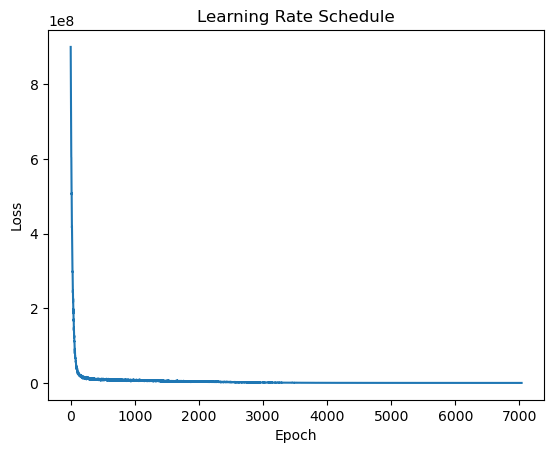

In [6]:
# Start Training
lrs = []
for epoch in range(NUM_EPOCHS):
    loop = tqdm(enumerate(train_loader))
    for i, (x, _) in loop:
        # Forward Pass
        x = x.to(DEVICE).view(x.shape[0], INPUT_DIM)
        x_reconstructed, mu, sigma = model(x)

        # Compute Loss
        reconstruction_loss = loss_fn(x_reconstructed, x)
        kl_div = -torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))

        # Backpropagate Error
        loss = reconstruction_loss * kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss=loss.item())
        lrs.append(loss.item())


        
plt.plot(lrs)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Rate Schedule')
plt.show()

        



In [7]:
model = model.to(DEVICE)
def inference(digit, num_examples=1):
    images = []
    idx = 0
    for x, y in dataset:
        if y == idx:
            images.append(x)
            idx += 1

        if idx == 10:
            break

    encodings_digit = []
    for d in range(10):
        with torch.no_grad():
            mu, sigma = model.encode(images[d].view(1, 784))
        encodings_digit.append((mu, sigma))
    

    mu, sigma = encodings_digit[digit]
    for example in range(num_examples):
        epsilon = torch.randn_like(sigma)
        z = mu + sigma * epsilon
        out = model.decode(z)
        out = out.view(-1, 1, 28, 28)
        save_image(out, f"generated/{digit}_ex{example}.png")


In [11]:
# Clean Generated Images
for filename in os.listdir(OUTPUT_DIR):
    file_path = os.path.join(OUTPUT_DIR, filename)
    if os.path.isfile(file_path):
        try:
            os.remove(file_path)
        except OSError as e:
            print(f"Error deleting file {file_path}: {e}")
    else:
        print(f"Skilling non-file item: {file_path}")


In [10]:

for idx in range(10):
    inference(idx, num_examples=3)
